(reinforcement_learning)=
# Fitting a Reinforcement Learning Model to Behavioral Data with PyMC

:::{post} Aug 5, 2022
:tags: PyTensor, Reinforcement Learning
:category: advanced, how-to
:author: Ricardo Vieira
:::


Reinforcement Learning models are commonly used in behavioral research to model how animals and humans learn, in situtions where they get to make repeated choices that are followed by some form of feedback, such as a reward or a punishment.

In this notebook we will consider the simplest learning scenario, where there are only two possible actions. When an action is taken, it is always followed by an immediate reward. Finally, the outcome of each action is independent from the previous actions taken. This scenario is sometimes referred to as the [multi-armed bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit).


Let's say that the two actions (e.g., left and right buttons) are associated with a unit reward 40% and 60% of the time, respectively. At the beginning the learning agent does not know which action $a$ is better, so they may start by assuming both actions have a mean value of 50%. We can store these values in a table, which is usually referred to as a $Q$ table:

$$ Q = \begin{cases}
      .5, a = \text{left}\\
      .5, a = \text{right}
    \end{cases}
$$

When an action is chosen and a reward $r = \{0,1\}$ is observed, the estimated value of that action is updated as follows:

$$Q_{a} = Q_{a} + \alpha (r - Q_{a})$$

where $\alpha \in [0, 1]$ is a learning parameter that influences how much the value of an action is shifted towards the observed reward in each trial. Finally, the $Q$ table values are converted into action probabilities via the softmax transformation:

$$ P(a = \text{right}) = \frac{\exp(\beta Q_{\text{right}})}{\exp(\beta Q_{\text{right}}) + \exp(\beta Q_{\text{left}})}$$

where the $\beta \in (0, +\infty)$ parameter determines the level of noise in the agent choices. Larger values will be associated with more deterministic choices and smaller values with increasingly random choices.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy

from matplotlib.lines import Line2D

In [2]:
seed = sum(map(ord, "RL_PyMC"))
rng = np.random.default_rng(seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Generating fake data

In [3]:
def generate_data(rng, alpha, beta, n=100, p_r=None):
    if p_r is None:
        p_r = [0.4, 0.6]
    actions = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([0.5, 0.5])
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta * Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = rng.choice([0, 1], p=prob_a)
        r = rng.random() < p_r[a]

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs

In [4]:
true_alpha = 0.5
true_beta = 5
n = 150
actions, rewards, Qs = generate_data(rng, true_alpha, true_beta, n)

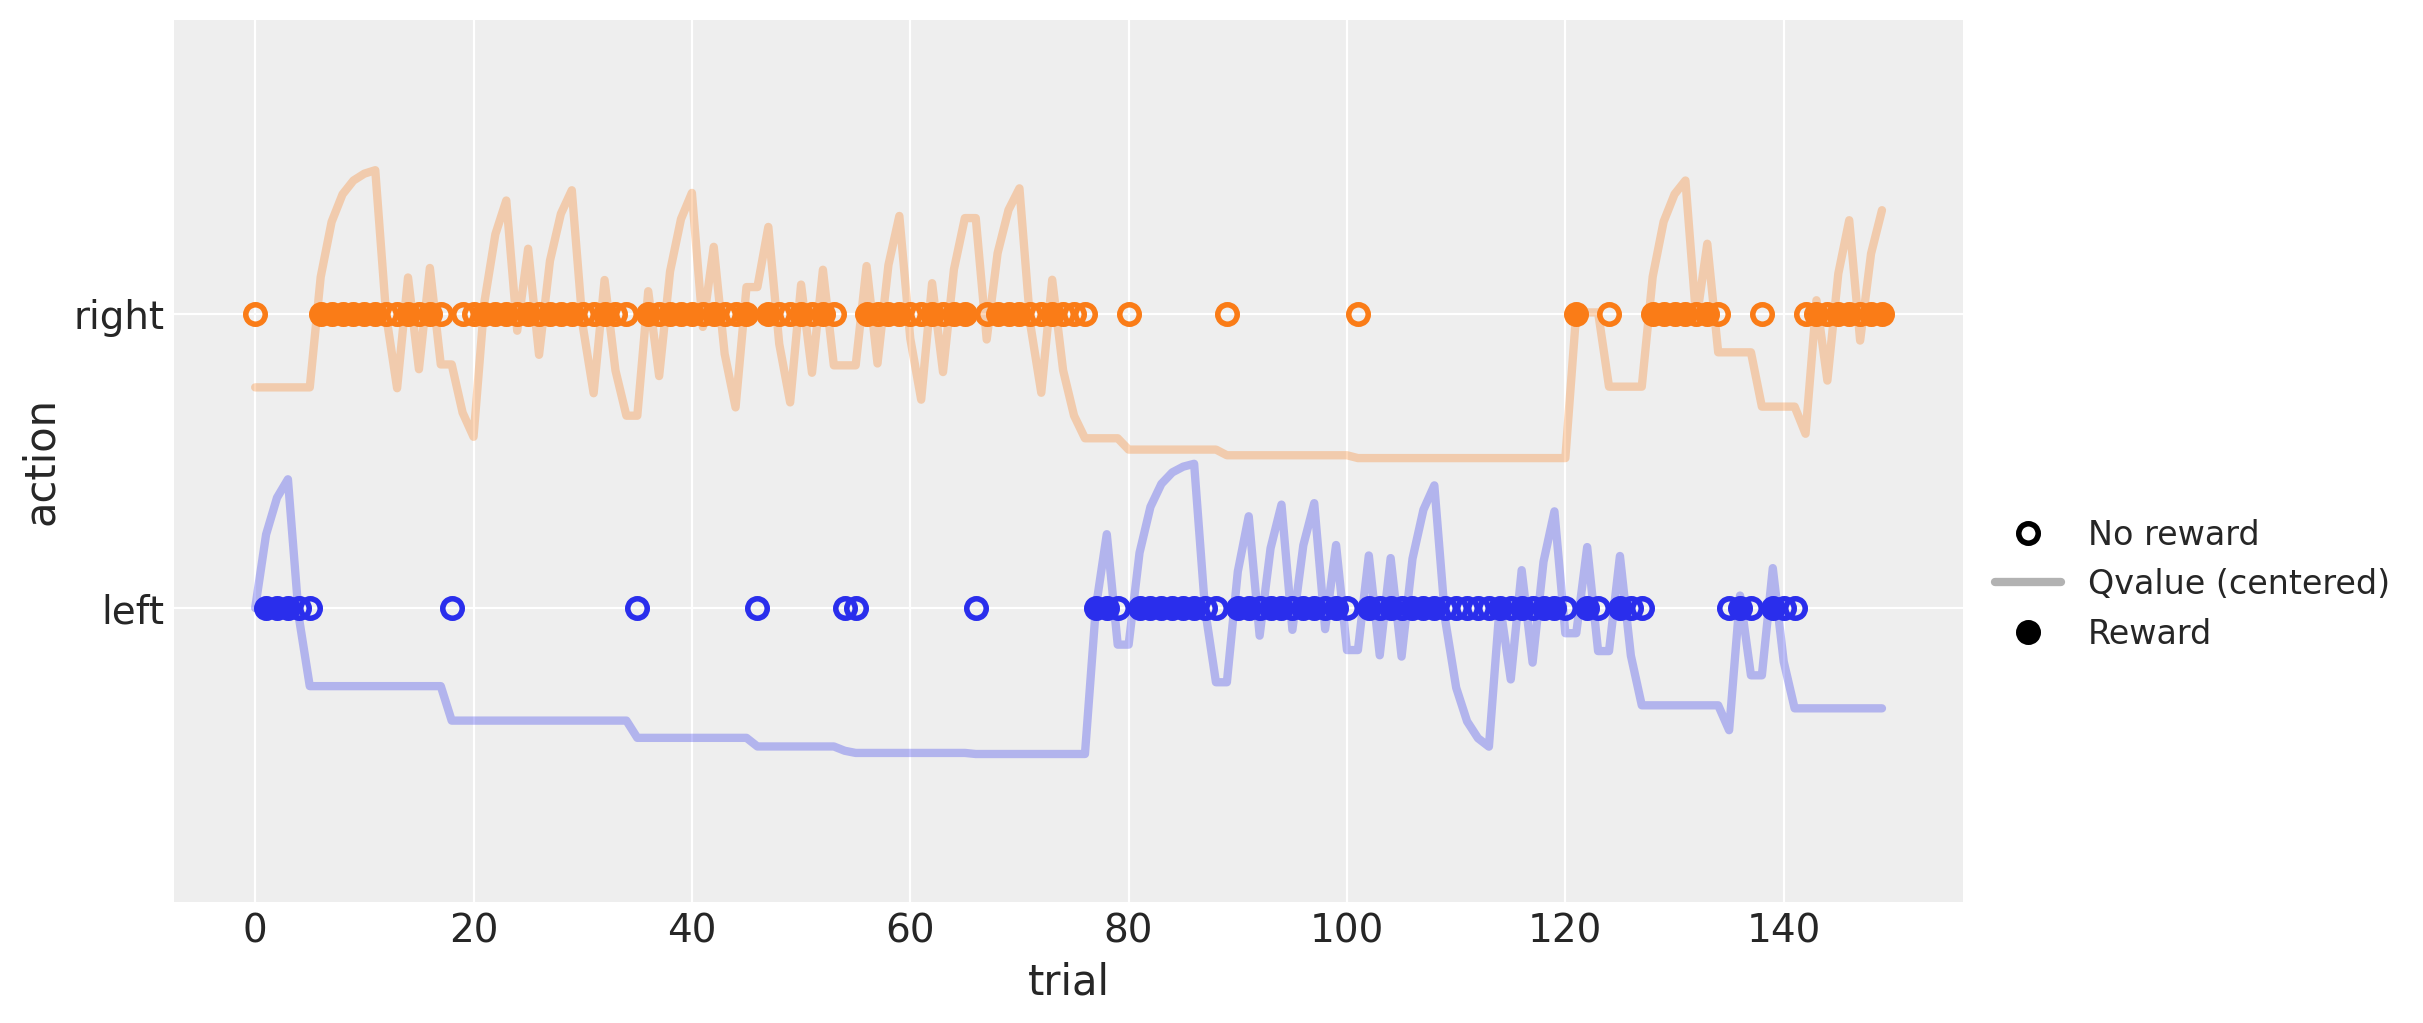

In [5]:
_, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(actions))

ax.plot(x, Qs[:, 0] - 0.5 + 0, c="C0", lw=3, alpha=0.3)
ax.plot(x, Qs[:, 1] - 0.5 + 1, c="C1", lw=3, alpha=0.3)

s = 7
lw = 2

cond = (actions == 0) & (rewards == 0)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="None", mec="C0", mew=lw)

cond = (actions == 0) & (rewards == 1)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="C0", mec="C0", mew=lw)

cond = (actions == 1) & (rewards == 0)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="None", mec="C1", mew=lw)

cond = (actions == 1) & (rewards == 1)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="C1", mec="C1", mew=lw)

ax.set_yticks([0, 1], ["left", "right"])
ax.set_ylim(-1, 2)
ax.set_ylabel("action")
ax.set_xlabel("trial")

reward_artist = Line2D([], [], c="k", ls="none", marker="o", ms=s, mew=lw, label="Reward")
no_reward_artist = Line2D(
    [], [], ls="none", marker="o", mfc="w", mec="k", ms=s, mew=lw, label="No reward"
)
Qvalue_artist = Line2D([], [], c="k", ls="-", lw=3, alpha=0.3, label="Qvalue (centered)")

ax.legend(handles=[no_reward_artist, Qvalue_artist, reward_artist], fontsize=12, loc=(1.01, 0.27));

The plot above shows a simulated run of 150 trials, with parameters $\alpha = .5$ and $\beta = 5$, and constant reward probabilities of $.4$ and $.6$ for the left (blue) and right (orange) actions, respectively. 

Solid and empty dots indicate actions followed by rewards and no-rewards, respectively. The solid line shows the estimated $Q$ value for each action centered around the respective colored dots (the line is above its dots when the respective $Q$ value is above $.5$, and below otherwise). It can be seen that this value increases with rewards (solid dots) and decreases with non-rewards (empty dots). 

The change in line height following each outcome is directly related to the $\alpha$ parameter. The influence of the $\beta$ parameter is more difficult to grasp, but one way to think about it is that the higher its value, the more an agent will stick to the action that has the highest estimated value, even if the difference between the two is quite small. Conversely, as this value approaches zero, the agent will start picking randomly between the two actions, regardless of their estimated values.

## Estimating the learning parameters via Maximum Likelihood

Having generated the data, the goal is to now 'invert the model' to estimate the learning parameters $\alpha$ and $\beta$. I start by doing it via Maximum Likelihood Estimation (MLE). This requires writing a custom function that computes the likelihood of the data given a potential $\alpha$ and $\beta$ and the fixed observed actions and rewards (actually the function computes the negative log likelihood, in order to avoid underflow issues).

I employ the handy scipy.optimize.minimize function, to quickly retrieve the values of $\alpha$ and $\beta$ that maximize the likelihood of the data (or actually, minimize the negative log likelihood).

This was also helpful when I later wrote the PyTensor function that computed the choice probabilities in PyMC. First, the underlying logic is the same, the only thing that changes is the syntax. Second, it provides a way to be confident that I did not mess up, and what I was actually computing was what I intended to.

In [6]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Initialize values
    Q = np.array([0.5, 0.5])
    logp_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions, rewards)):
        # Apply the softmax transformation
        Q_ = Q * beta
        logp_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        logp_actions[t] = logp_action[a]

        # Update the Q values for the next trial
        Q[a] = Q[a] + alpha * (r - Q[a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(logp_actions[1:])

The function `llik_td` is strikingly similar to the `generate_data` one, except that instead of simulating an action and reward in each trial, it stores the log-probability of the observed action.

The function `scipy.special.logsumexp` is used to compute the term $\log(\exp(\beta Q_{\text{right}}) + \exp(\beta Q_{\text{left}}))$ in a way that is more numerically stable. 

In the end, the function returns the negative sum of all the log probabilities, which is equivalent to multiplying the probabilities in their original scale.

(The first action is ignored just to make the output comparable to the later PyTensor function. It doesn't actually change any estimation, as the initial probabilities are fixed and do not depend on either the $\alpha$ or $\beta$ parameters.)

In [7]:
llik_td([true_alpha, true_beta], *(actions, rewards))

47.418936097207016

Above, I computed the negative log likelihood of the data given the true $\alpha$ and $\beta$ parameters.

Below, I let scipy find the MLE values for the two parameters:

In [8]:
x0 = [true_alpha, true_beta]
result = scipy.optimize.minimize(llik_td, x0, args=(actions, rewards), method="BFGS")
print(result)
print("")
print(f"MLE: alpha = {result.x[0]:.2f} (true value = {true_alpha})")
print(f"MLE: beta = {result.x[1]:.2f} (true value = {true_beta})")

      fun: 47.050814541102895
 hess_inv: array([[ 0.00733307, -0.02421781],
       [-0.02421781,  0.86969299]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([0.50473117, 5.7073849 ])

MLE: alpha = 0.50 (true value = 0.5)
MLE: beta = 5.71 (true value = 5)


The estimated MLE values are relatively close to the true ones. However, this procedure does not give any idea of the plausible uncertainty around these parameter values. To get that, I'll turn to PyMC for a bayesian posterior estimation.

But before that, I will implement a simple vectorization optimization to the log-likelihood function that will be more similar to the PyTensor counterpart. The reason for this is to speed up the slow bayesian inference engine down the road.

In [9]:
def llik_td_vectorized(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Create a list with the Q values of each trial
    Qs = np.ones((n, 2), dtype="float64")
    Qs[0] = 0.5
    for t, (a, r) in enumerate(
        zip(actions[:-1], rewards[:-1])
    ):  # The last Q values were never used, so there is no need to compute them
        Qs[t + 1, a] = Qs[t, a] + alpha * (r - Qs[t, a])
        Qs[t + 1, 1 - a] = Qs[t, 1 - a]

    # Apply the softmax transformation in a vectorized way
    Qs_ = Qs * beta
    logp_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]

    # Return the logp_actions for the observed actions
    logp_actions = logp_actions[np.arange(len(actions)), actions]
    return -np.sum(logp_actions[1:])

In [10]:
llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))

47.418936097207016

In [11]:
%timeit llik_td([true_alpha, true_beta], *(actions, rewards))

7.13 ms ± 832 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))

653 µs ± 119 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The vectorized function gives the same results, but runs almost one order of magnitude faster. 

When implemented as an PyTensor function, the difference between the vectorized and standard versions was not this drastic. Still, it ran twice as fast, which meant the model also sampled at twice the speed it would otherwise have!

## Estimating the learning parameters via PyMC

The most challenging part was to create an PyTensor function/loop to estimate the Q values when sampling our parameters with PyMC.

In [13]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [14]:
# Transform the variables into appropriate PyTensor objects
rewards_ = pt.as_tensor_variable(rewards, dtype="int32")
actions_ = pt.as_tensor_variable(actions, dtype="int32")

alpha = pt.scalar("alpha")
beta = pt.scalar("beta")

# Initialize the Q table
Qs = 0.5 * pt.ones((2,), dtype="float64")

# Compute the Q values for each trial
Qs, _ = pytensor.scan(
    fn=update_Q, sequences=[actions_, rewards_], outputs_info=[Qs], non_sequences=[alpha]
)

# Apply the softmax transformation
Qs = Qs * beta
logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

# Calculate the negative log likelihod of the observed actions
logp_actions = logp_actions[pt.arange(actions_.shape[0] - 1), actions_[1:]]
neg_loglike = -pt.sum(logp_actions)

Let's wrap it up in a function to test out if it's working as expected.

In [15]:
pytensor_llik_td = pytensor.function(
    inputs=[alpha, beta], outputs=neg_loglike, on_unused_input="ignore"
)
result = pytensor_llik_td(true_alpha, true_beta)
float(result)

47.418936097206995

The same result is obtained, so we can be confident that the PyTensor loop is working as expected. We are now ready to implement the PyMC model.

In [16]:
def pytensor_llik_td(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

    # Calculate the log likelihood of the observed actions
    logp_actions = logp_actions[pt.arange(actions.shape[0] - 1), actions[1:]]
    return pt.sum(logp_actions)  # PyMC expects the standard log-likelihood

In [17]:
with pm.Model() as m:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    like = pm.Potential(name="like", var=pytensor_llik_td(alpha, beta, actions, rewards))

    tr = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


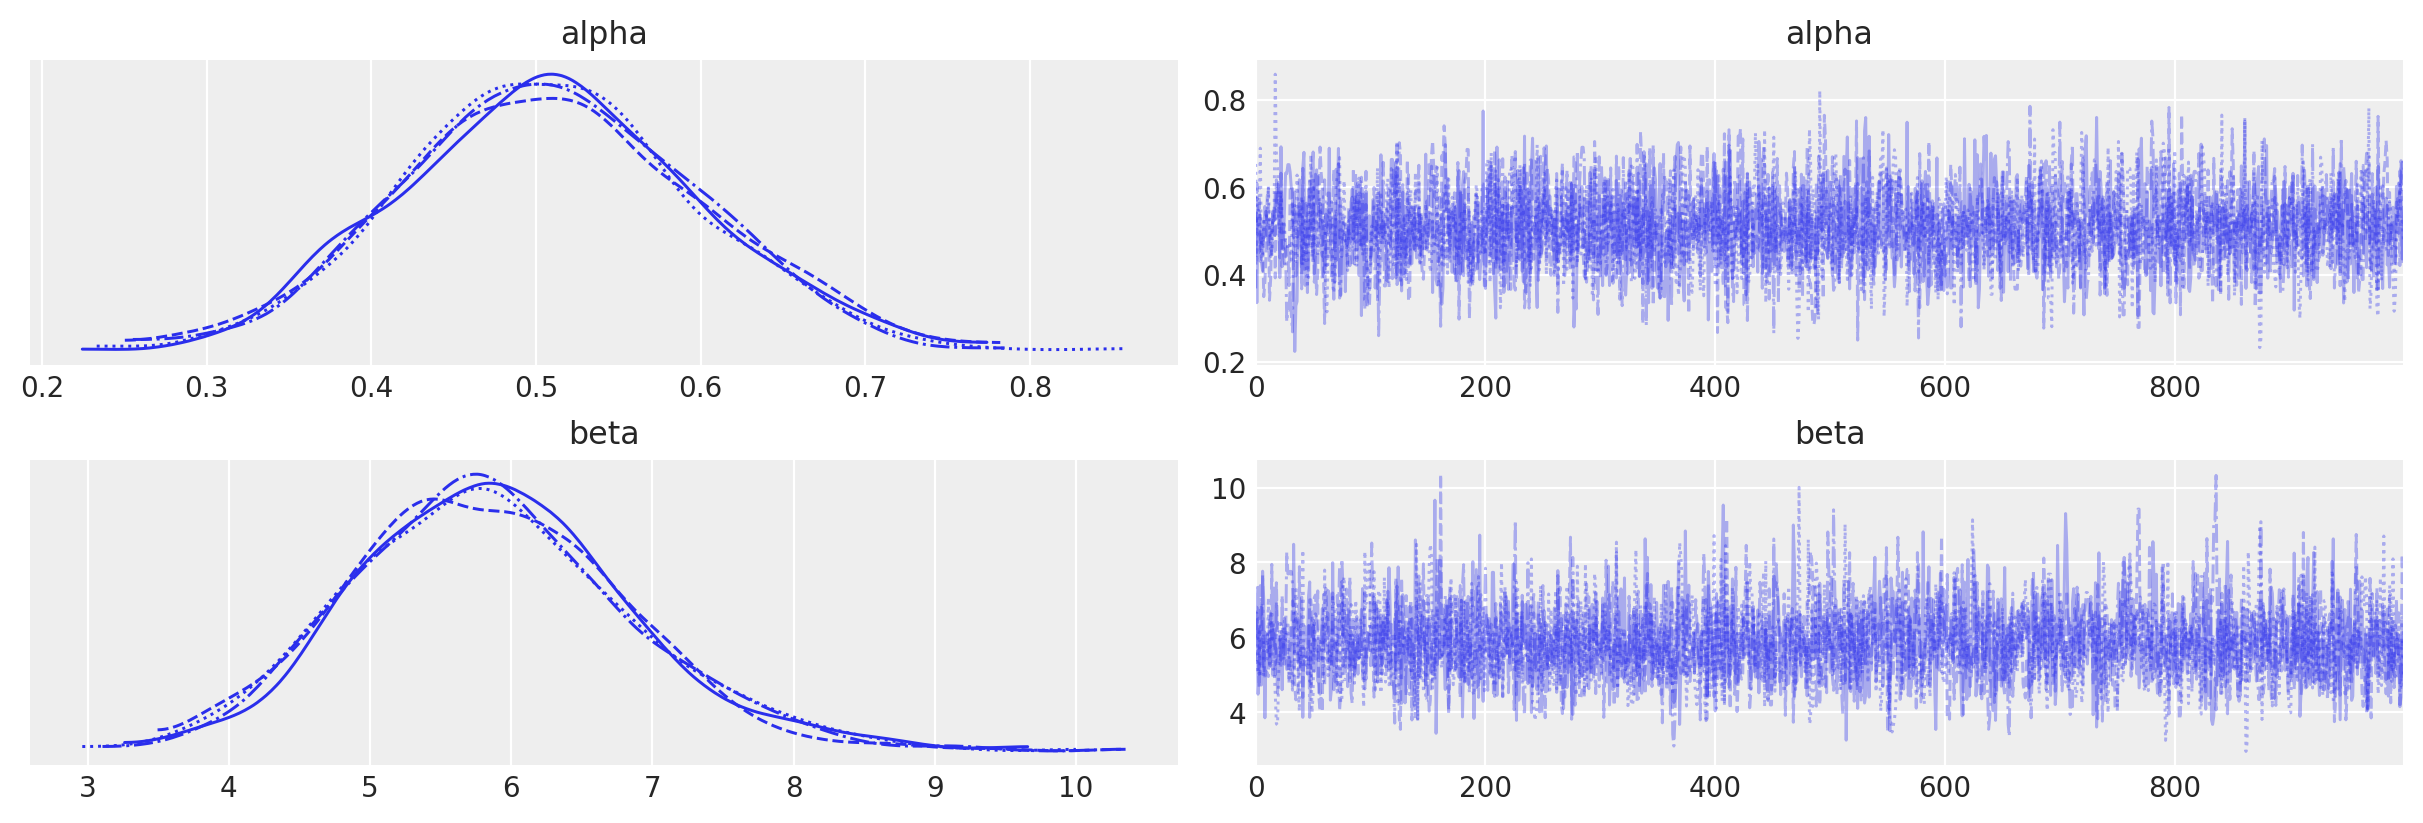

In [18]:
az.plot_trace(data=tr);

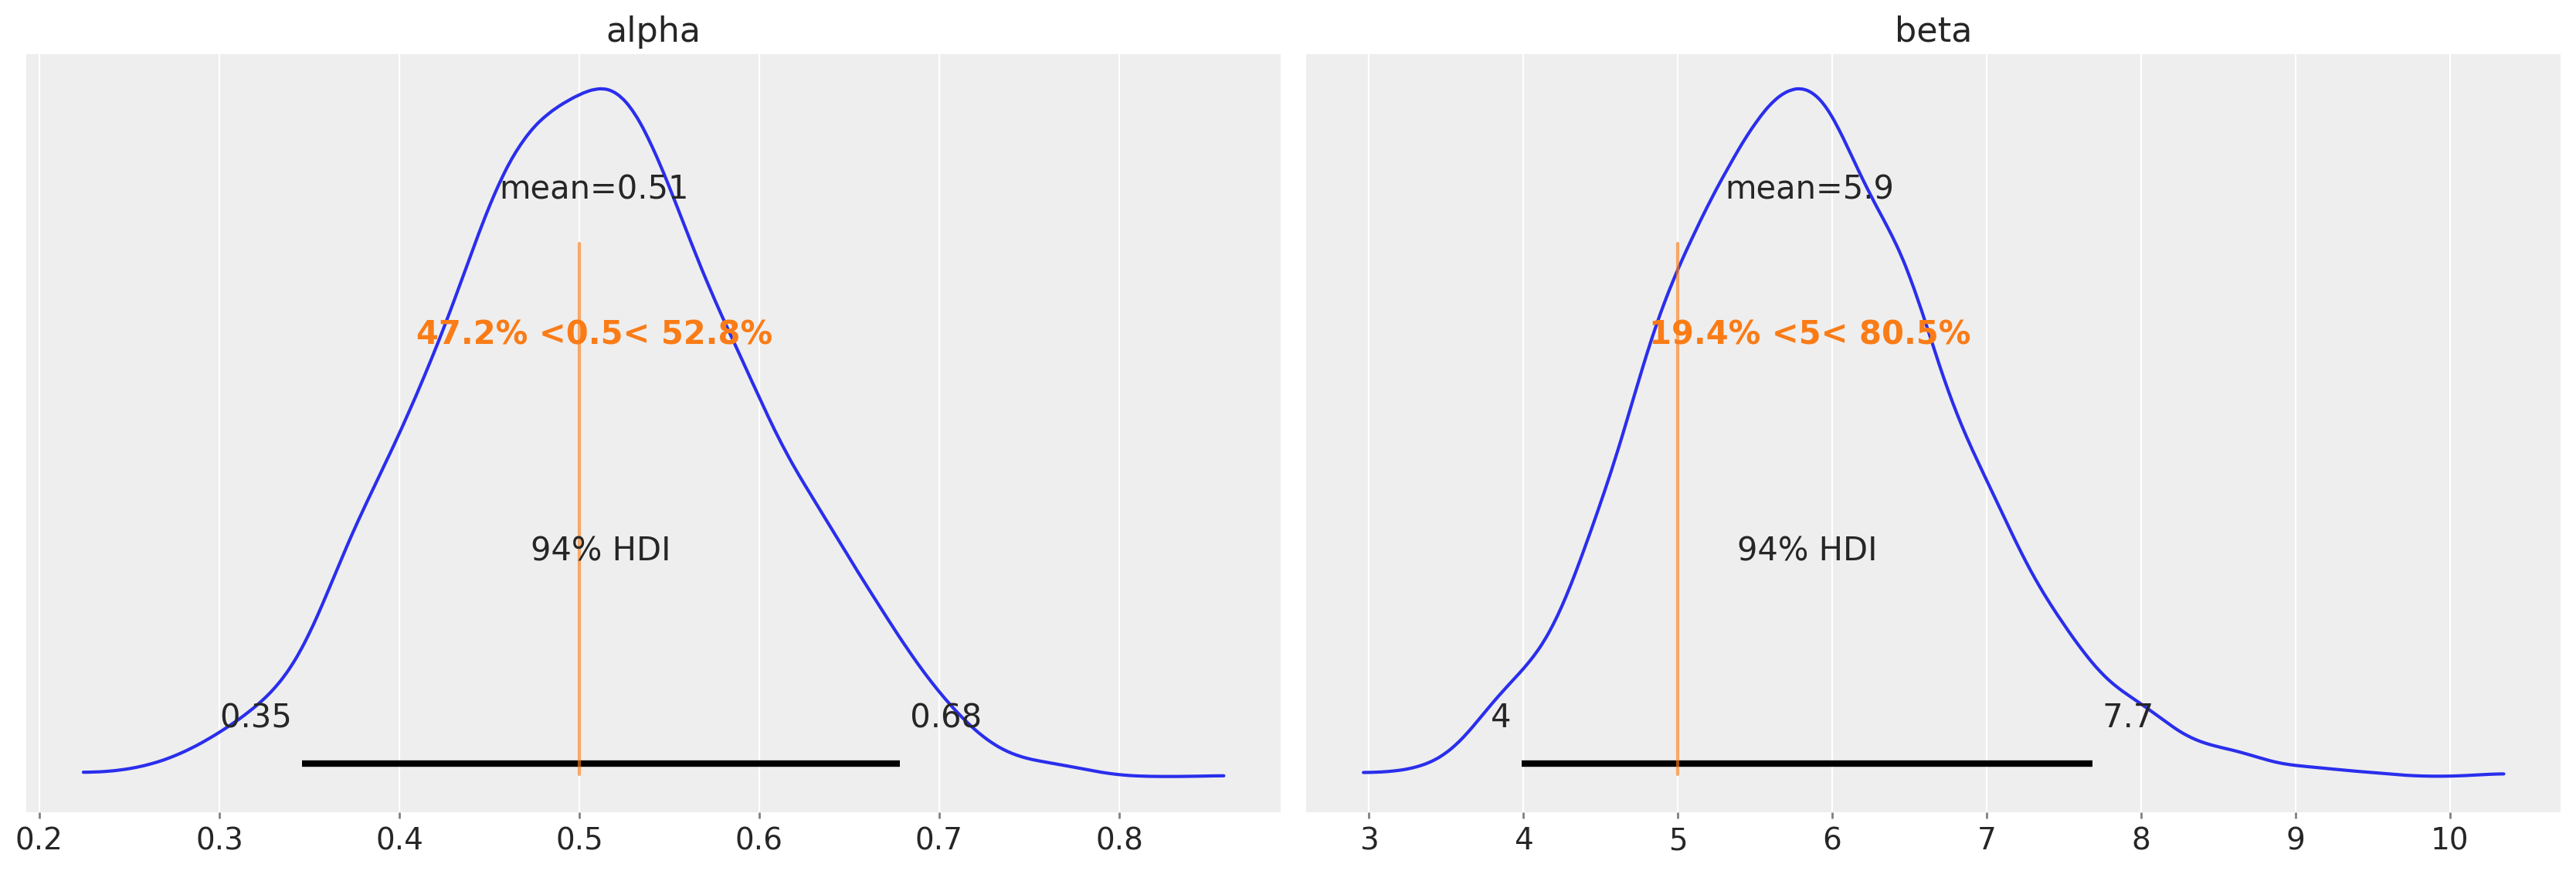

In [19]:
az.plot_posterior(data=tr, ref_val=[true_alpha, true_beta]);

In this example, the obtained posteriors are nicely centered around the MLE values. What we have gained is an idea of the plausible uncertainty around these values.

### Alternative model using Bernoulli for the likelihood

In this last section I provide an alternative implementation of the model using a Bernoulli likelihood.

:::{Note}
One reason why it's useful to use the Bernoulli likelihood is that one can then do prior and posterior predictive sampling as well as model comparison. With `pm.Potential` you cannot do it, because PyMC does not know what is likelihood and what is prior nor how to generate random draws. Neither of this is a problem when using a `pm.Bernoulli` likelihood.
:::

In [20]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

    # Return the probabilities for the right action, in the original scale
    return pt.exp(logp_actions[:, 1])

In [21]:
with pm.Model() as m_alt:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    action_probs = right_action_probs(alpha, beta, actions, rewards)
    like = pm.Bernoulli(name="like", p=action_probs, observed=actions[1:])

    tr_alt = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


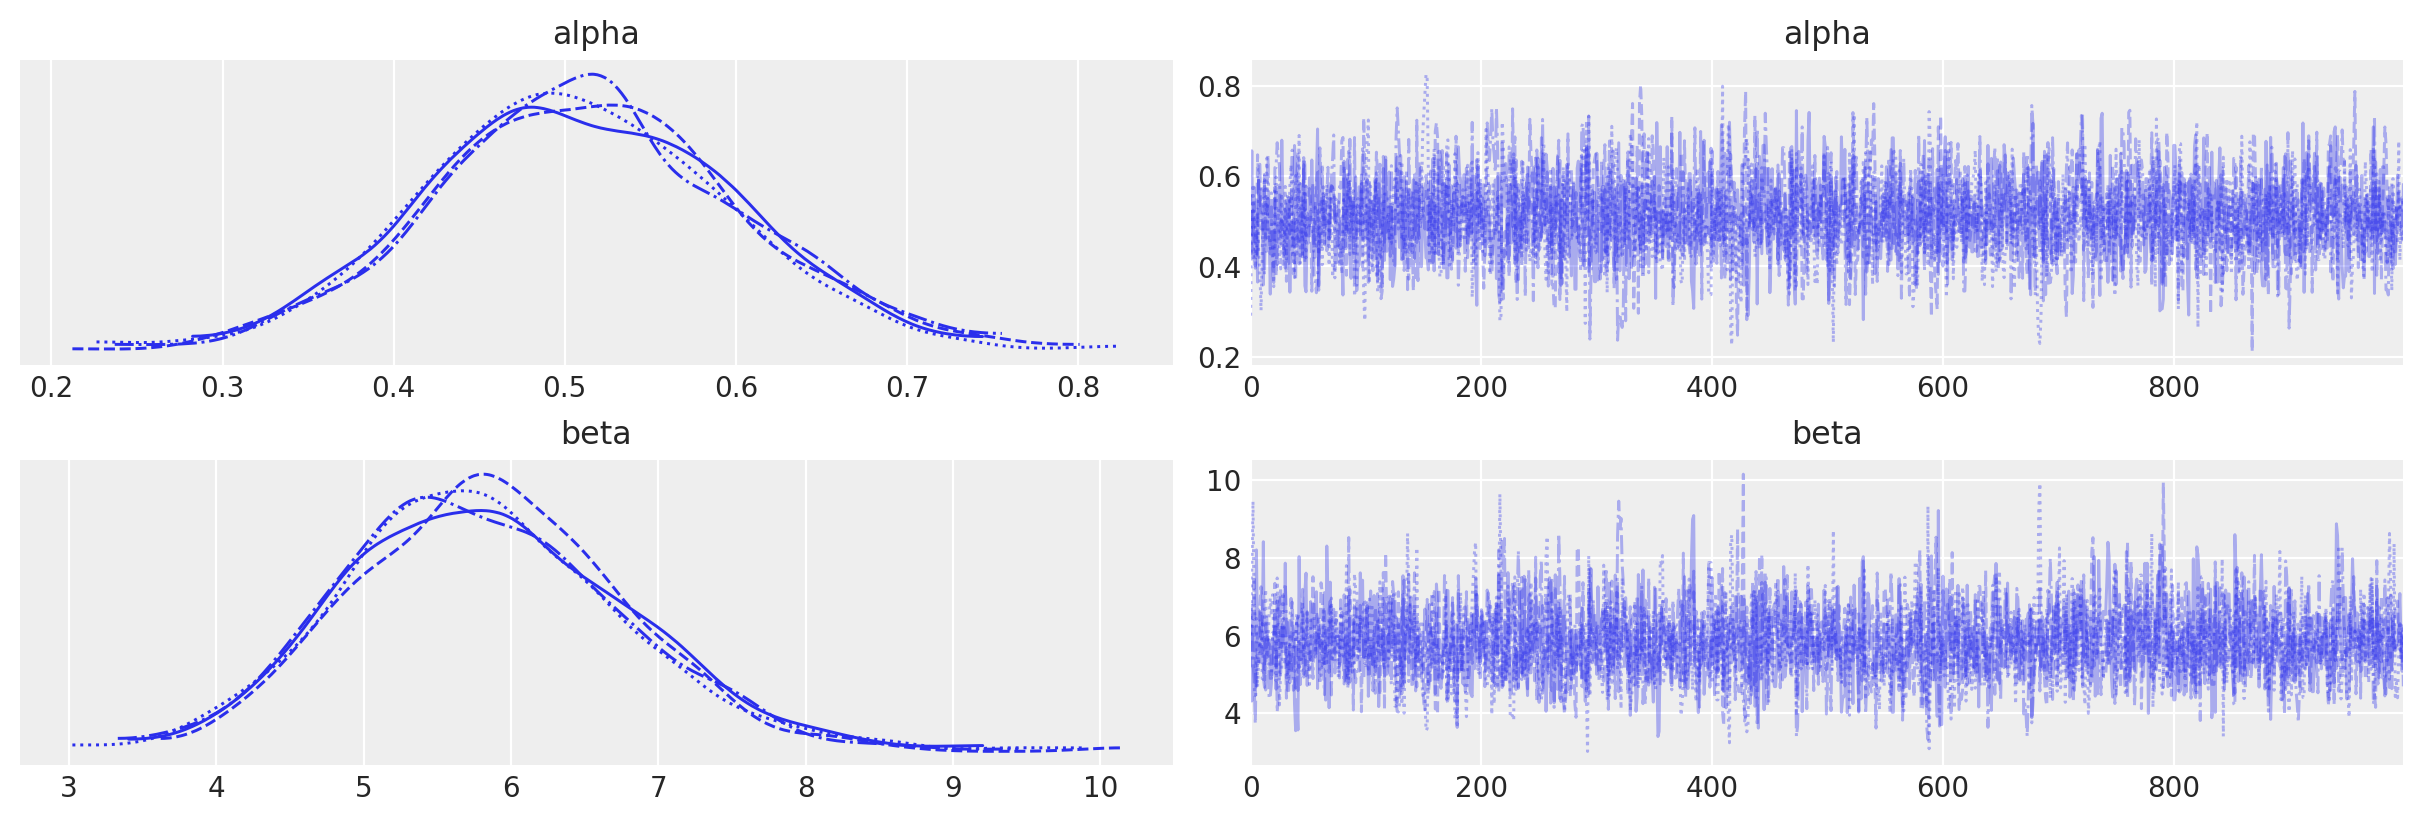

In [22]:
az.plot_trace(data=tr_alt);

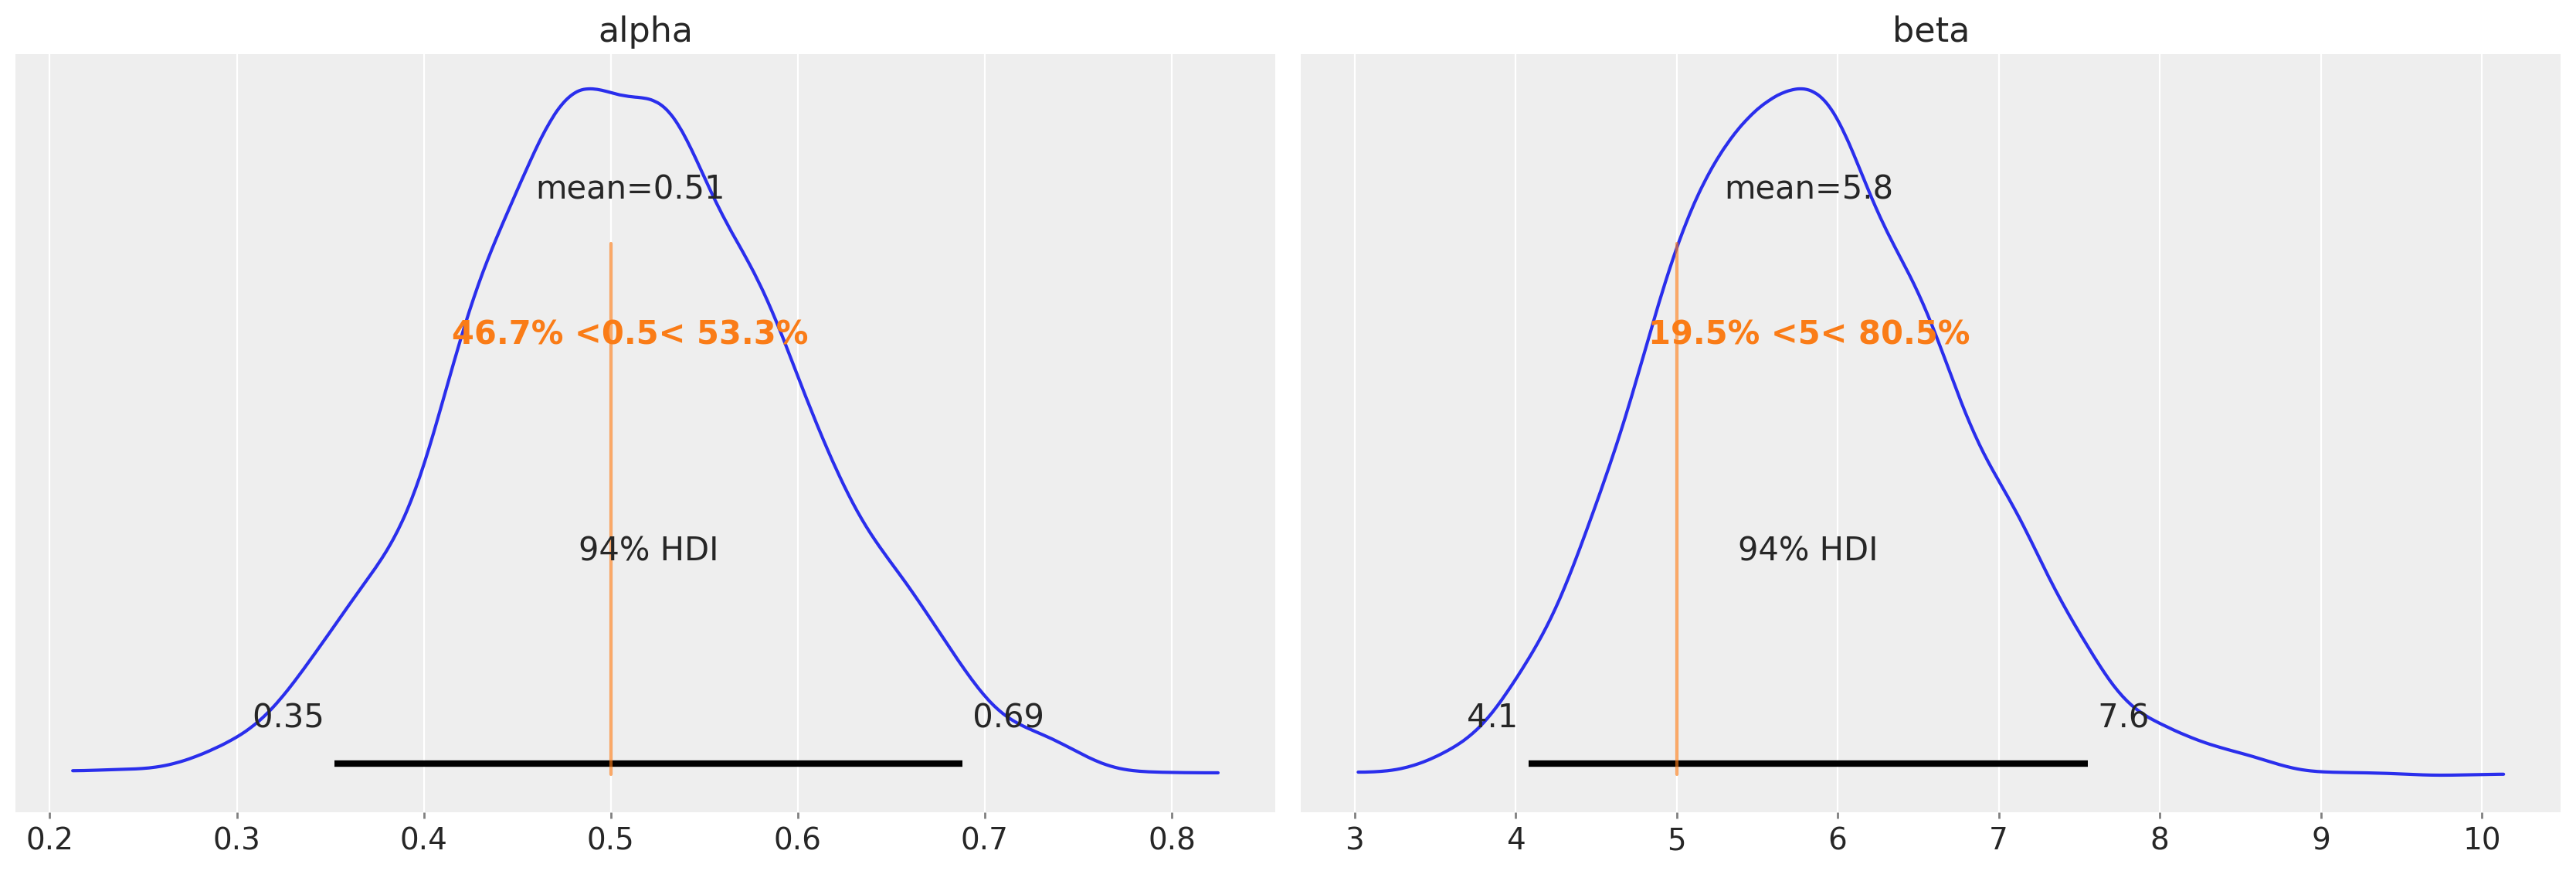

In [23]:
az.plot_posterior(data=tr_alt, ref_val=[true_alpha, true_beta]);

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aeppl,xarray

Last updated: Thu Aug 18 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

aeppl : 0.0.34
xarray: 2022.6.0

pytensor    : 2.7.9
arviz     : 0.12.1
pymc      : 4.1.5
sys       : 3.9.13 (main, May 24 2022, 21:28:31) 
[Clang 13.1.6 (clang-1316.0.21.2)]
scipy     : 1.8.1
numpy     : 1.22.4
matplotlib: 3.5.3

Watermark: 2.3.1



## References

:::{bibliography}
:filter: docname in docnames
:::

## Credits

* Authored by [Ricardo Vieira](https://github.com/ricardov94) in June 2022

  * Adapted PyMC code from Maria Eckstein ([GitHub](https://github.com/MariaEckstein/SLCN), [PyMC Discourse](https://discourse.pymc.io/t/modeling-reinforcement-learning-of-human-participant-using-pymc3/1735))

  * Adapted MLE code from Robert Wilson and Anne Collins {cite:p}`collinswilson2019` ([GitHub](https://github.com/AnneCollins/TenSimpleRulesModeling))

* Re-executed by [Juan Orduz](https://juanitorduz.github.io/) in August 2022 ([pymc-examples#410](https://github.com/pymc-devs/pymc-examples/pull/410))

:::{include} ../page_footer.md
:::